## <b><u>Walmart Sales Capstone </b></u>
Eric West <br>
Springboard Data Analytics Certification Course <br>
Mentor: Ioannis Loukakis <br>
November 2023 <br>
<br>
Note: This notebook has been revised to include only the most relevant code to quarterly driver analysis.  For additional code/analysis, please contact at eric.m.west@outlook.com
<br>
<br>
Data Source: https://www.kaggle.com/datasets/asahu40/walmart-data-analysis-and-forcasting/data 

### Table of Contents

<u>Section I:</u>    Importing Libraries and Data, Defining Functions <br>
<u>Section II:</u>   Exploring and Cleaning Initial Data <br>
<u>Section III:</u>  General Feature Engineering <br>
<u>Section IV:</u>   Quarterly Feature Engineering <br>
<u>Section V:</u>    Filtered Datasets <br>
<u>Section VI:</u>   Visualization <br>
<u>Section VII:</u>   Driver Analysis <br>

### Section I: Importing Libraries and Data, Defining Functions

<b> Import libraries

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm

<b> Import data

In [2]:
ws_initial = pd.read_csv('walmart_initial_data.csv')

holidays_excel = pd.ExcelFile('holidays.xlsx')
holidays_excel_worksheets = holidays_excel.sheet_names
holidays_df = pd.read_excel(holidays_excel,holidays_excel_worksheets[-1])
holidays_df['Date'] = pd.to_datetime(holidays_df['Date'],dayfirst=True).dt.date

<b> Define Functions </b>

In [3]:
def holidays(dates, holiday_table):
        # Create function dataframe
    df = pd.DataFrame()
    df['Date'] = dates
        
        # Create weeks column
    weeks = []
    for i in range(len(df['Date'])):
            weeks.append([(df.loc[i,'Date']),(df.loc[i,'Date']+datetime.timedelta(days=1)),\
                         (df.loc[i,'Date']+datetime.timedelta(days=2)),\
                         (df.loc[i,'Date']+datetime.timedelta(days=3)),\
                         (df.loc[i,'Date']+datetime.timedelta(days=4)),\
                         (df.loc[i,'Date']+datetime.timedelta(days=5)),\
                         (df.loc[i,'Date']+datetime.timedelta(days=6))])
    df['Days_of_Week'] = weeks
        
        # Create list of holidays for each date
     
    for i in range(len(df['Days_of_Week'])):
        holidays_in_week = []
        
        for j in range(len(holiday_table['Date'])):
            if holiday_table.loc[j,'Date'] in df.loc[i,'Days_of_Week']:
                holidays_in_week.append(holiday_table.loc[j,'Holiday_Name'])
        stringed_holidays_in_week = ''
        
        for k in range(len(holidays_in_week)):
            if k == 0:
                stringed_holidays_in_week += holidays_in_week[k]
            else:
                stringed_holidays_in_week += (', '+holidays_in_week[k])
        
        df.loc[i,'Holiday_Names'] = str(stringed_holidays_in_week)
        
        # Create holiday flags for each date
    for i in range(len(df['Holiday_Names'])):
        if df.loc[i,'Holiday_Names'] == '':
            df.loc[i,'Holiday_Flag'] = 0
        else:
            df.loc[i,'Holiday_Flag'] = 1
    df_e = df.drop('Days_of_Week',axis=1)         
    return df_e

In [4]:
def week_shift(dataset, shift_columns, n_week_shift):
    # create each desired column
    for cols in shift_columns:
        dataset[str(n_week_shift)+'-'+'wk_prior'+'_'+str(cols)] = pd.Series(dtype=float)
    store_dict = {}
    # segment table into stores
    for i in range(len(dataset['Store'].unique())):
        store_dict[str(i+1)] = dataset[dataset['Store']==str(i+1)].copy()
    # order store tables by date
    for stores in store_dict.keys():
        store_dict[stores].sort_values('Date',ascending=True,inplace=True)
    # shift by target weeks to new columns
        for cols in shift_columns:
            store_dict[stores][str(n_week_shift)+'-'+'wk_prior'+'_'+str(cols)] = \
                store_dict[stores][cols].shift(periods=n_week_shift)
    dataset_out = pd.concat(store_dict).reset_index(drop=True)   
    return dataset_out

In [5]:
def month_shift(dataset, shift_columns, n_week_shift):
    # create each desired column
    for cols in shift_columns:
        dataset[str(n_week_shift)+'-'+'mo_prior'+'_'+str(cols)] = pd.Series(dtype=float)
    store_dict = {}
    # segment table into stores
    for i in range(len(dataset['Store'].unique())):
        store_dict[str(i+1)] = dataset[dataset['Store']==str(i+1)].copy()
    # order store tables by date
    for stores in store_dict.keys():
        store_dict[stores].sort_values(['Year','Month'],inplace=True)
    # shift by target weeks to new columns
        for cols in shift_columns:
            store_dict[stores][str(n_week_shift)+'-'+'mo_prior'+'_'+str(cols)] = \
                store_dict[stores][cols].shift(periods=n_week_shift)
    dataset_out = pd.concat(store_dict).reset_index(drop=True)   
    return dataset_out

In [6]:
def quarter_shift(dataset, shift_columns, n_week_shift):
    # create each desired column
    for cols in shift_columns:
        dataset[str(n_week_shift)+'-'+'q_prior'+'_'+str(cols)] = pd.Series(dtype=float)
    store_dict = {}
    # segment table into stores
    for i in range(len(dataset['Store'].unique())):
        store_dict[str(i+1)] = dataset[dataset['Store']==str(i+1)].copy()
    # order store tables by date
    for stores in store_dict.keys():
        store_dict[stores].sort_values(['Fiscal_Year','Fiscal_Quarter'],inplace=True)
    # shift by target weeks to new columns
        for cols in shift_columns:
            store_dict[stores][str(n_week_shift)+'-'+'q_prior'+'_'+str(cols)] = \
                store_dict[stores][cols].shift(periods=n_week_shift)
    dataset_out = pd.concat(store_dict).reset_index(drop=True)   
    return dataset_out

In [7]:
def float_hists(df):
    for column in df.columns:
        if type(df[column][0])==np.float64:
            bin_width = 3.49*np.std(df[column])*(len(df[column])**(-1/3)) # Scott's Rule for Bin Width
            flt_range = np.max(df[column])-np.min(df[column])
            bin_no = int(flt_range/bin_width)
            plt.hist(df[column],bins=bin_no) 
            plt.title('Frequency of ' + column) 
            plt.xlabel(column)
            plt.xticks(rotation=90)
            plt.ylabel('Frequency')
            plt.show()
        else:
            print(str(column)+' is non-float')
    return

In [8]:
def nonfloat_freq(df):
    for column in df.columns:
        if type(df[column][0])!=np.float64:
            plt.bar(df[column].unique(),df[column].value_counts())
            plt.title('Frequency of ' + column)
            plt.xlabel(column)
            plt.xticks(rotation=90)
            plt.ylabel('Frequency')
            plt.show()
        else:
            print(str(column)+' is float')
    return

In [9]:
def var_combiner(df,cont_cols, dum_cols):
    combined_col_names = []
    for cont_col in cont_cols:
        for dum_col in dum_cols:
            combined_col_names.append(str(cont_col)+'_'+str(dum_col))
    combined_df = pd.DataFrame(index=df.index,columns=combined_col_names)
    for cont_col in cont_cols:
        for dum_col in dum_cols:
            combined_df[str(cont_col)+'_'+str(dum_col)] = df[cont_col]*df[dum_col]
    combined_df_out = df.merge(combined_df,left_index=True,right_index=True)
    return combined_df_out


### Section II: Exploring and Cleaning Initial Data

#### Dataframe

In [10]:
display(ws_initial)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


In [11]:
ws_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [12]:
ws_initial.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [13]:
display(holidays_df)

,Holiday_Name,Date
0,Valentine's Day,2010-02-14
1,Presidents' Day,2010-02-15
2,St. Patrick's Day,2010-03-17
3,Easter,2010-04-04
4,Mother's Day,2010-05-09
...,...,...
67,Black Friday,2013-11-29
68,Cyber Monday,2013-12-02
69,Christmas Day,2013-12-25
70,New Year's Day,2014-01-01


#### Stores

In [14]:
print('Store data type: ', type(ws_initial['Store'][0]))
print('Store Numbers: ', ws_initial['Store'].unique())
print('Records per Store: ', ws_initial['Store'].value_counts().unique())

Store data type:  <class 'numpy.int64'>
Store Numbers:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
Records per Store:  [143]


Observation: store number is currently integer <br>
Objective: convert store number to string

In [15]:
ws_initial['Store'] = ws_initial['Store'].astype(str)
ws_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   object 
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 402.3+ KB


#### Dates

In [16]:
print('Date data type: ', type(ws_initial['Date'][0]))
print('Unique Dates: ', ws_initial['Date'].unique())
print('Records per Date: ', ws_initial['Date'].value_counts().unique())

Date data type:  <class 'str'>
Unique Dates:  ['05-02-2010' '12-02-2010' '19-02-2010' '26-02-2010' '05-03-2010'
 '12-03-2010' '19-03-2010' '26-03-2010' '02-04-2010' '09-04-2010'
 '16-04-2010' '23-04-2010' '30-04-2010' '07-05-2010' '14-05-2010'
 '21-05-2010' '28-05-2010' '04-06-2010' '11-06-2010' '18-06-2010'
 '25-06-2010' '02-07-2010' '09-07-2010' '16-07-2010' '23-07-2010'
 '30-07-2010' '06-08-2010' '13-08-2010' '20-08-2010' '27-08-2010'
 '03-09-2010' '10-09-2010' '17-09-2010' '24-09-2010' '01-10-2010'
 '08-10-2010' '15-10-2010' '22-10-2010' '29-10-2010' '05-11-2010'
 '12-11-2010' '19-11-2010' '26-11-2010' '03-12-2010' '10-12-2010'
 '17-12-2010' '24-12-2010' '31-12-2010' '07-01-2011' '14-01-2011'
 '21-01-2011' '28-01-2011' '04-02-2011' '11-02-2011' '18-02-2011'
 '25-02-2011' '04-03-2011' '11-03-2011' '18-03-2011' '25-03-2011'
 '01-04-2011' '08-04-2011' '15-04-2011' '22-04-2011' '29-04-2011'
 '06-05-2011' '13-05-2011' '20-05-2011' '27-05-2011' '03-06-2011'
 '10-06-2011' '17-06-2011' '24

Observation: dates are stored as strings <br>
Objective: convert to datetime type

In [17]:
ws_initial['Date'] = pd.to_datetime(ws_initial['Date'],dayfirst=True).dt.date

In [18]:
display(ws_initial)
ws_initial.info()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   object 
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 402.3+ KB


#### Weekly Sales

In [19]:
valid_sales = ws_initial['Weekly_Sales']>=0
if False not in valid_sales.unique():
    print('All Weekly_Sales Valid')
else:
    print('Weekly_Sale(s) Invalid')

All Weekly_Sales Valid


#### Holiday Flag

In [20]:
display(ws_initial[ws_initial['Holiday_Flag']==True]['Date'].unique())

array([datetime.date(2010, 2, 12), datetime.date(2010, 9, 10),
       datetime.date(2010, 11, 26), datetime.date(2010, 12, 31),
       datetime.date(2011, 2, 11), datetime.date(2011, 9, 9),
       datetime.date(2011, 11, 25), datetime.date(2011, 12, 30),
       datetime.date(2012, 2, 10), datetime.date(2012, 9, 7)],
      dtype=object)

In [21]:
holidays_in_week = holidays(ws_initial['Date'].unique(),holidays_df)
ws_initial.drop(labels='Holiday_Flag',axis=1,inplace=True)
ws_initial = ws_initial.merge(holidays_in_week,on='Date')
ws_initial['Holiday_Flag'] = ws_initial['Holiday_Flag'].astype(int)
display(ws_initial)

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Holiday_Names,Holiday_Flag
0,1,2010-02-05,1643690.90,42.31,2.572,211.096358,8.106,,0
1,2,2010-02-05,2136989.46,40.19,2.572,210.752605,8.324,,0
2,3,2010-02-05,461622.22,45.71,2.572,214.424881,7.368,,0
3,4,2010-02-05,2135143.87,43.76,2.598,126.442065,8.623,,0
4,5,2010-02-05,317173.10,39.70,2.572,211.653972,6.566,,0
...,...,...,...,...,...,...,...,...,...
6430,41,2012-10-26,1316542.59,41.80,3.686,199.219532,6.195,Halloween,1
6431,42,2012-10-26,514756.08,70.50,4.301,131.193097,6.943,Halloween,1
6432,43,2012-10-26,587603.55,69.17,3.506,214.741539,8.839,Halloween,1
6433,44,2012-10-26,361067.07,46.97,3.755,131.193097,5.217,Halloween,1


#### Temperature

In [22]:
ws_initial['Temperature'].describe()

count    6435.000000
mean       60.663782
std        18.444933
min        -2.060000
25%        47.460000
50%        62.670000
75%        74.940000
max       100.140000
Name: Temperature, dtype: float64

Observation: temperatures in expected range

#### Fuel Price

In [23]:
ws_initial['Fuel_Price'].describe()

count    6435.000000
mean        3.358607
std         0.459020
min         2.472000
25%         2.933000
50%         3.445000
75%         3.735000
max         4.468000
Name: Fuel_Price, dtype: float64

Observation: fuel prices in expected range

#### CPI

In [24]:
ws_initial['CPI'].describe()

count    6435.000000
mean      171.578394
std        39.356712
min       126.064000
25%       131.735000
50%       182.616521
75%       212.743293
max       227.232807
Name: CPI, dtype: float64

Observation: cpi values in expected range

#### Unemployment

In [25]:
ws_initial['Unemployment'].describe()

count    6435.000000
mean        7.999151
std         1.875885
min         3.879000
25%         6.891000
50%         7.874000
75%         8.622000
max        14.313000
Name: Unemployment, dtype: float64

Observation: unemployment values in expected range

#### <b> Section II Final Dataset

In [26]:
display(ws_initial)
#ws_initial.to_csv('walmart_cleaned_initial_data.csv')

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Holiday_Names,Holiday_Flag
0,1,2010-02-05,1643690.90,42.31,2.572,211.096358,8.106,,0
1,2,2010-02-05,2136989.46,40.19,2.572,210.752605,8.324,,0
2,3,2010-02-05,461622.22,45.71,2.572,214.424881,7.368,,0
3,4,2010-02-05,2135143.87,43.76,2.598,126.442065,8.623,,0
4,5,2010-02-05,317173.10,39.70,2.572,211.653972,6.566,,0
...,...,...,...,...,...,...,...,...,...
6430,41,2012-10-26,1316542.59,41.80,3.686,199.219532,6.195,Halloween,1
6431,42,2012-10-26,514756.08,70.50,4.301,131.193097,6.943,Halloween,1
6432,43,2012-10-26,587603.55,69.17,3.506,214.741539,8.839,Halloween,1
6433,44,2012-10-26,361067.07,46.97,3.755,131.193097,5.217,Halloween,1


### Section III: General Feature Engineering

In [27]:
ws_general = ws_initial.copy()

<b> Potential Parameters </b>
- Sales Volume Groups 
- CPI Groups 
- CPI Level (Over 150, Below 150)

#### Date Deconstruction

In [28]:
for i in range(len(ws_general)):
    ws_general.loc[i,'Month'] = ws_general.loc[i,'Date'].month
    ws_general.loc[i,'Year'] = ws_general.loc[i,'Date'].year
    if (ws_general.loc[i,'Month'] >= 2) & (ws_general.loc[i,'Month'] < 5):
        ws_general.loc[i,'Fiscal_Quarter'] = 1
        ws_general.loc[i,'Fiscal_Year'] =  ws_general.loc[i,'Year']
    elif (ws_general.loc[i,'Month'] >= 5) & (ws_general.loc[i,'Month'] < 8):
        ws_general.loc[i,'Fiscal_Quarter'] = 2
        ws_general.loc[i,'Fiscal_Year'] = ws_general.loc[i,'Year']
    elif (ws_general.loc[i,'Month'] >= 8) & (ws_general.loc[i,'Month'] < 11):
        ws_general.loc[i,'Fiscal_Quarter'] = 3
        ws_general.loc[i,'Fiscal_Year'] = ws_general.loc[i,'Year']
    else:
        ws_general.loc[i,'Fiscal_Quarter'] = 4
        if ws_general.loc[i,'Month'] == 1: 
            ws_general.loc[i,'Fiscal_Year'] = ws_general.loc[i,'Year'] - 1
        else: 
            ws_general.loc[i,'Fiscal_Year'] = ws_general.loc[i,'Year']
ws_general[['Month','Year','Fiscal_Quarter','Fiscal_Year']] = \
    ws_general[['Month','Year','Fiscal_Quarter','Fiscal_Year']].astype(int)

#### Sales Volume Groups

In [29]:
avg_sales_per_store = pd.DataFrame(ws_general.groupby('Store')['Weekly_Sales'].agg('mean'))\
    .reset_index().rename({0:'Weekly_Sales'},axis=1)
for i in range(len(avg_sales_per_store)):
    if avg_sales_per_store.loc[i,'Weekly_Sales'] >= 1650000: avg_sales_per_store.loc[i,'Sales_Volume_Group'] = 'Largest'
    elif avg_sales_per_store.loc[i,'Weekly_Sales'] >= 1250000: avg_sales_per_store.loc[i,'Sales_Volume_Group'] = 'Large'
    elif avg_sales_per_store.loc[i,'Weekly_Sales'] >= 850000: avg_sales_per_store.loc[i,'Sales_Volume_Group'] = 'Medium'
    elif avg_sales_per_store.loc[i,'Weekly_Sales'] >= 450000: avg_sales_per_store.loc[i,'Sales_Volume_Group'] = 'Small'
    else: avg_sales_per_store.loc[i,'Sales_Volume_Group'] = 'Smallest'
display(avg_sales_per_store)

,Store,Weekly_Sales,Sales_Volume_Group
0,1,1.555264e+06,Large
1,10,1.899425e+06,Largest
2,11,1.356383e+06,Large
3,12,1.009002e+06,Medium
4,13,2.003620e+06,Largest
5,14,2.020978e+06,Largest
6,15,6.233125e+05,Small
7,16,5.192477e+05,Small
8,17,8.935814e+05,Medium
9,18,1.084718e+06,Medium


In [30]:
avg_sales_per_store.drop(labels='Weekly_Sales',axis=1,inplace=True)
ws_general = ws_general.merge(avg_sales_per_store,on='Store')
display(ws_general)

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Holiday_Names,Holiday_Flag,Month,Year,Fiscal_Quarter,Fiscal_Year,Sales_Volume_Group
0,1,2010-02-05,1643690.90,42.31,2.572,211.096358,8.106,,0,2,2010,1,2010,Large
1,1,2010-02-12,1641957.44,38.51,2.548,211.242170,8.106,"Valentine's Day, Presidents' Day",1,2,2010,1,2010,Large
2,1,2010-02-19,1611968.17,39.93,2.514,211.289143,8.106,,0,2,2010,1,2010,Large
3,1,2010-02-26,1409727.59,46.63,2.561,211.319643,8.106,,0,2,2010,1,2010,Large
4,1,2010-03-05,1554806.68,46.50,2.625,211.350143,8.106,,0,3,2010,1,2010,Large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,64.88,3.997,192.013558,8.684,,0,9,2012,3,2012,Small
6431,45,2012-10-05,733455.07,64.89,3.985,192.170412,8.667,Columbus Day,1,10,2012,3,2012,Small
6432,45,2012-10-12,734464.36,54.47,4.000,192.327265,8.667,,0,10,2012,3,2012,Small
6433,45,2012-10-19,718125.53,56.47,3.969,192.330854,8.667,,0,10,2012,3,2012,Small


#### CPI Groups

In [31]:
cpi_groups = ws_general[['Store','Date','CPI']].groupby(['Date','CPI']).agg({'Store':'unique'}).reset_index()['Store'].values[0:15]
store_cpi_group = pd.DataFrame(ws_general['Store'].unique()).rename({0:'Store'},axis=1)
for i in range(len(store_cpi_group)):
    for j in range(len(cpi_groups)):
        if store_cpi_group.loc[i,'Store'] in cpi_groups[j]:
            store_cpi_group.loc[i,'CPI_Group'] = 'cpi_Region ' + str(j+1)
display(store_cpi_group)

,Store,CPI_Group
0,1,cpi_Region 10
1,2,cpi_Region 9
2,3,cpi_Region 13
3,4,cpi_Region 1
4,5,cpi_Region 11
5,6,cpi_Region 12
6,7,cpi_Region 5
7,8,cpi_Region 14
8,9,cpi_Region 15
9,10,cpi_Region 1


In [32]:
ws_general = ws_general.merge(store_cpi_group,on='Store')
display(ws_general)

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Holiday_Names,Holiday_Flag,Month,Year,Fiscal_Quarter,Fiscal_Year,Sales_Volume_Group,CPI_Group
0,1,2010-02-05,1643690.90,42.31,2.572,211.096358,8.106,,0,2,2010,1,2010,Large,cpi_Region 10
1,1,2010-02-12,1641957.44,38.51,2.548,211.242170,8.106,"Valentine's Day, Presidents' Day",1,2,2010,1,2010,Large,cpi_Region 10
2,1,2010-02-19,1611968.17,39.93,2.514,211.289143,8.106,,0,2,2010,1,2010,Large,cpi_Region 10
3,1,2010-02-26,1409727.59,46.63,2.561,211.319643,8.106,,0,2,2010,1,2010,Large,cpi_Region 10
4,1,2010-03-05,1554806.68,46.50,2.625,211.350143,8.106,,0,3,2010,1,2010,Large,cpi_Region 10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,64.88,3.997,192.013558,8.684,,0,9,2012,3,2012,Small,cpi_Region 4
6431,45,2012-10-05,733455.07,64.89,3.985,192.170412,8.667,Columbus Day,1,10,2012,3,2012,Small,cpi_Region 4
6432,45,2012-10-12,734464.36,54.47,4.000,192.327265,8.667,,0,10,2012,3,2012,Small,cpi_Region 4
6433,45,2012-10-19,718125.53,56.47,3.969,192.330854,8.667,,0,10,2012,3,2012,Small,cpi_Region 4


#### CPI Level

In [33]:
for i in range(len(ws_general)):
    if ws_general.loc[i,'CPI'] >= 150: ws_general.loc[i,'CPI_Level'] = 'High'
    else: ws_general.loc[i,'CPI_Level'] = 'Low'

In [34]:
display(ws_general)

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Holiday_Names,Holiday_Flag,Month,Year,Fiscal_Quarter,Fiscal_Year,Sales_Volume_Group,CPI_Group,CPI_Level
0,1,2010-02-05,1643690.90,42.31,2.572,211.096358,8.106,,0,2,2010,1,2010,Large,cpi_Region 10,High
1,1,2010-02-12,1641957.44,38.51,2.548,211.242170,8.106,"Valentine's Day, Presidents' Day",1,2,2010,1,2010,Large,cpi_Region 10,High
2,1,2010-02-19,1611968.17,39.93,2.514,211.289143,8.106,,0,2,2010,1,2010,Large,cpi_Region 10,High
3,1,2010-02-26,1409727.59,46.63,2.561,211.319643,8.106,,0,2,2010,1,2010,Large,cpi_Region 10,High
4,1,2010-03-05,1554806.68,46.50,2.625,211.350143,8.106,,0,3,2010,1,2010,Large,cpi_Region 10,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,64.88,3.997,192.013558,8.684,,0,9,2012,3,2012,Small,cpi_Region 4,High
6431,45,2012-10-05,733455.07,64.89,3.985,192.170412,8.667,Columbus Day,1,10,2012,3,2012,Small,cpi_Region 4,High
6432,45,2012-10-12,734464.36,54.47,4.000,192.327265,8.667,,0,10,2012,3,2012,Small,cpi_Region 4,High
6433,45,2012-10-19,718125.53,56.47,3.969,192.330854,8.667,,0,10,2012,3,2012,Small,cpi_Region 4,High


#### <b> Section III Final Dataset

In [35]:
display(ws_general)
ws_general.info()

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Holiday_Names,Holiday_Flag,Month,Year,Fiscal_Quarter,Fiscal_Year,Sales_Volume_Group,CPI_Group,CPI_Level
0,1,2010-02-05,1643690.90,42.31,2.572,211.096358,8.106,,0,2,2010,1,2010,Large,cpi_Region 10,High
1,1,2010-02-12,1641957.44,38.51,2.548,211.242170,8.106,"Valentine's Day, Presidents' Day",1,2,2010,1,2010,Large,cpi_Region 10,High
2,1,2010-02-19,1611968.17,39.93,2.514,211.289143,8.106,,0,2,2010,1,2010,Large,cpi_Region 10,High
3,1,2010-02-26,1409727.59,46.63,2.561,211.319643,8.106,,0,2,2010,1,2010,Large,cpi_Region 10,High
4,1,2010-03-05,1554806.68,46.50,2.625,211.350143,8.106,,0,3,2010,1,2010,Large,cpi_Region 10,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,64.88,3.997,192.013558,8.684,,0,9,2012,3,2012,Small,cpi_Region 4,High
6431,45,2012-10-05,733455.07,64.89,3.985,192.170412,8.667,Columbus Day,1,10,2012,3,2012,Small,cpi_Region 4,High
6432,45,2012-10-12,734464.36,54.47,4.000,192.327265,8.667,,0,10,2012,3,2012,Small,cpi_Region 4,High
6433,45,2012-10-19,718125.53,56.47,3.969,192.330854,8.667,,0,10,2012,3,2012,Small,cpi_Region 4,High


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6435 entries, 0 to 6434
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Store               6435 non-null   object 
 1   Date                6435 non-null   object 
 2   Weekly_Sales        6435 non-null   float64
 3   Temperature         6435 non-null   float64
 4   Fuel_Price          6435 non-null   float64
 5   CPI                 6435 non-null   float64
 6   Unemployment        6435 non-null   float64
 7   Holiday_Names       6435 non-null   object 
 8   Holiday_Flag        6435 non-null   int32  
 9   Month               6435 non-null   int32  
 10  Year                6435 non-null   int32  
 11  Fiscal_Quarter      6435 non-null   int32  
 12  Fiscal_Year         6435 non-null   int32  
 13  Sales_Volume_Group  6435 non-null   object 
 14  CPI_Group           6435 non-null   object 
 15  CPI_Level           6435 non-null   object 
dtypes: flo

### Section IV: Quarterly Feature Engineering

In [36]:
ws_general_quarterly = ws_general.copy()

<b> Potential Parameters </b>
- Prior Sales
- Change in Sales
- Lagging Economic Indicators
- Leading Economic Indicators (Using data from future, not good, but what about forecasted?)
- Change in Economic Indicators
- Group-based combination variables

#### Group Data

In [37]:
ws_quarterly = ws_general_quarterly.groupby(['Store','Fiscal_Quarter','Fiscal_Year',\
                                          'Sales_Volume_Group','CPI_Group','CPI_Level']).agg(
    total_sales = pd.NamedAgg(column='Weekly_Sales',aggfunc='sum'),
    avg_sales = pd.NamedAgg(column='Weekly_Sales',aggfunc='mean'),
    avg_temp = pd.NamedAgg(column='Temperature',aggfunc='mean'),
    avg_cpi = pd.NamedAgg(column='CPI',aggfunc='mean'),
    avg_fuel_price = pd.NamedAgg(column='Fuel_Price',aggfunc='mean'),
    avg_unemployment = pd.NamedAgg(column='Unemployment',aggfunc='mean')).reset_index()
display(ws_quarterly)

,Store,Fiscal_Quarter,Fiscal_Year,Sales_Volume_Group,CPI_Group,CPI_Level,total_sales,avg_sales,avg_temp,avg_cpi,avg_fuel_price,avg_unemployment
0,1,1,2010,Large,cpi_Region 10,High,19601440.00,1.507803e+06,54.184615,210.974804,2.677769,7.991385
1,1,1,2011,Large,cpi_Region 10,High,20396386.65,1.568953e+06,60.622308,214.267338,3.410385,7.718923
2,1,1,2012,Large,cpi_Region 10,High,21511287.13,1.654714e+06,61.433077,221.030320,3.690154,7.284923
3,1,2,2010,Large,cpi_Region 10,High,19258503.14,1.481423e+06,80.270769,211.050275,2.701462,7.799923
4,1,2,2011,Large,cpi_Region 10,High,19551057.85,1.503928e+06,81.095385,215.394788,3.691385,7.789692
...,...,...,...,...,...,...,...,...,...,...,...,...
490,9,3,2010,Small,cpi_Region 15,High,6353721.99,4.887478e+05,76.843846,215.199467,2.642077,6.487385
491,9,3,2011,Small,cpi_Region 15,High,6936615.81,5.335858e+05,78.693077,219.982185,3.470000,6.296308
492,9,3,2012,Small,cpi_Region 15,High,7153840.04,5.502954e+05,76.638462,226.438945,3.607077,5.177615
493,9,4,2010,Small,cpi_Region 15,High,7407910.36,5.698393e+05,49.217692,215.208712,2.858231,6.515692


#### 1-Quarter Prior Sales, CPI, Fuel Price, Unemployment, and Temperature.

In [38]:
ws_quarterly = quarter_shift(ws_quarterly, ['total_sales','avg_sales','avg_temp','avg_cpi','avg_fuel_price','avg_unemployment'],1)
display(ws_quarterly)

,Store,Fiscal_Quarter,Fiscal_Year,Sales_Volume_Group,CPI_Group,CPI_Level,total_sales,avg_sales,avg_temp,avg_cpi,avg_fuel_price,avg_unemployment,1-q_prior_total_sales,1-q_prior_avg_sales,1-q_prior_avg_temp,1-q_prior_avg_cpi,1-q_prior_avg_fuel_price,1-q_prior_avg_unemployment
0,1,1,2010,Large,cpi_Region 10,High,19601440.00,1.507803e+06,54.184615,210.974804,2.677769,7.991385,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,2010,Large,cpi_Region 10,High,19258503.14,1.481423e+06,80.270769,211.050275,2.701462,7.799923,19601440.00,1.507803e+06,54.184615,210.974804,2.677769,7.991385
2,1,3,2010,Large,cpi_Region 10,High,19056388.62,1.465876e+06,77.806154,211.651038,2.642077,7.806615,19258503.14,1.481423e+06,80.270769,211.050275,2.701462,7.799923
3,1,4,2010,Large,cpi_Region 10,High,20842551.21,1.603273e+06,50.155385,211.674877,2.858231,7.808462,19056388.62,1.465876e+06,77.806154,211.651038,2.642077,7.806615
4,1,1,2011,Large,cpi_Region 10,High,20396386.65,1.568953e+06,60.622308,214.267338,3.410385,7.718923,20842551.21,1.603273e+06,50.155385,211.674877,2.858231,7.808462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,45,3,2011,Small,cpi_Region 4,High,9661366.82,7.431821e+05,67.496923,187.008997,3.685154,8.593615,10169645.51,7.822804e+05,72.203077,185.946172,3.882077,8.561000
491,45,4,2011,Small,cpi_Region 4,High,11604623.60,8.926634e+05,42.708462,188.768282,3.476615,8.492538,9661366.82,7.431821e+05,67.496923,187.008997,3.685154,8.593615
492,45,1,2012,Small,cpi_Region 4,High,10259780.79,7.892139e+05,48.052308,190.339410,3.857000,8.468000,11604623.60,8.926634e+05,42.708462,188.768282,3.476615,8.492538
493,45,2,2012,Small,cpi_Region 4,High,10263547.59,7.895037e+05,71.473846,191.057802,3.678385,8.603000,10259780.79,7.892139e+05,48.052308,190.339410,3.857000,8.468000


#### 4-Quarter Prior Sales, CPI, Fuel Price, Unemployment, and Temperature

In [39]:
ws_quarterly = quarter_shift(ws_quarterly, ['total_sales','avg_sales','avg_temp','avg_cpi','avg_fuel_price','avg_unemployment'],4)
display(ws_quarterly)

,Store,Fiscal_Quarter,Fiscal_Year,Sales_Volume_Group,CPI_Group,CPI_Level,total_sales,avg_sales,avg_temp,avg_cpi,...,1-q_prior_avg_temp,1-q_prior_avg_cpi,1-q_prior_avg_fuel_price,1-q_prior_avg_unemployment,4-q_prior_total_sales,4-q_prior_avg_sales,4-q_prior_avg_temp,4-q_prior_avg_cpi,4-q_prior_avg_fuel_price,4-q_prior_avg_unemployment
0,1,1,2010,Large,cpi_Region 10,High,19601440.00,1.507803e+06,54.184615,210.974804,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,2010,Large,cpi_Region 10,High,19258503.14,1.481423e+06,80.270769,211.050275,...,54.184615,210.974804,2.677769,7.991385,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,2010,Large,cpi_Region 10,High,19056388.62,1.465876e+06,77.806154,211.651038,...,80.270769,211.050275,2.701462,7.799923,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,2010,Large,cpi_Region 10,High,20842551.21,1.603273e+06,50.155385,211.674877,...,77.806154,211.651038,2.642077,7.806615,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,2011,Large,cpi_Region 10,High,20396386.65,1.568953e+06,60.622308,214.267338,...,50.155385,211.674877,2.858231,7.808462,19601440.00,1.507803e+06,54.184615,210.974804,2.677769,7.991385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,45,3,2011,Small,cpi_Region 4,High,9661366.82,7.431821e+05,67.496923,187.008997,...,72.203077,185.946172,3.882077,8.561000,9420725.52,7.246712e+05,68.268462,182.686519,2.779462,8.735692
491,45,4,2011,Small,cpi_Region 4,High,11604623.60,8.926634e+05,42.708462,188.768282,...,67.496923,187.008997,3.685154,8.593615,11398827.53,8.768329e+05,35.684615,182.756142,3.105077,8.670154
492,45,1,2012,Small,cpi_Region 4,High,10259780.79,7.892139e+05,48.052308,190.339410,...,42.708462,188.768282,3.476615,8.492538,9819136.17,7.553182e+05,43.575385,184.738134,3.561000,8.538231
493,45,2,2012,Small,cpi_Region 4,High,10263547.59,7.895037e+05,71.473846,191.057802,...,48.052308,190.339410,3.857000,8.468000,10169645.51,7.822804e+05,72.203077,185.946172,3.882077,8.561000


#### 1-Quarter Change in Sales, CPI, Fuel Price, Unemployment, and Temperature.

In [40]:
ws_quarterly['1-q_diff_total_sales'] = ws_quarterly['total_sales'] - ws_quarterly['1-q_prior_total_sales']
ws_quarterly['1-q_diff_avg_sales'] = ws_quarterly['avg_sales'] - ws_quarterly['1-q_prior_avg_sales']
ws_quarterly['1-q_diff_cpi'] = ws_quarterly['avg_cpi'] - ws_quarterly['1-q_prior_avg_cpi']
ws_quarterly['1-q_diff_temperature'] = ws_quarterly['avg_temp'] - ws_quarterly['1-q_prior_avg_temp']
ws_quarterly['1-q_diff_fuel_price'] = ws_quarterly['avg_fuel_price'] - ws_quarterly['1-q_prior_avg_fuel_price']
ws_quarterly['1-q_diff_unemployment'] = ws_quarterly['avg_unemployment'] - ws_quarterly['1-q_prior_avg_unemployment']
display(ws_quarterly)

,Store,Fiscal_Quarter,Fiscal_Year,Sales_Volume_Group,CPI_Group,CPI_Level,total_sales,avg_sales,avg_temp,avg_cpi,...,4-q_prior_avg_temp,4-q_prior_avg_cpi,4-q_prior_avg_fuel_price,4-q_prior_avg_unemployment,1-q_diff_total_sales,1-q_diff_avg_sales,1-q_diff_cpi,1-q_diff_temperature,1-q_diff_fuel_price,1-q_diff_unemployment
0,1,1,2010,Large,cpi_Region 10,High,19601440.00,1.507803e+06,54.184615,210.974804,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,2010,Large,cpi_Region 10,High,19258503.14,1.481423e+06,80.270769,211.050275,...,NaN,NaN,NaN,NaN,-342936.86,-26379.758462,0.075471,26.086154,0.023692,-0.191462
2,1,3,2010,Large,cpi_Region 10,High,19056388.62,1.465876e+06,77.806154,211.651038,...,NaN,NaN,NaN,NaN,-202114.52,-15547.270769,0.600763,-2.464615,-0.059385,0.006692
3,1,4,2010,Large,cpi_Region 10,High,20842551.21,1.603273e+06,50.155385,211.674877,...,NaN,NaN,NaN,NaN,1786162.59,137397.122308,0.023839,-27.650769,0.216154,0.001846
4,1,1,2011,Large,cpi_Region 10,High,20396386.65,1.568953e+06,60.622308,214.267338,...,54.184615,210.974804,2.677769,7.991385,-446164.56,-34320.350769,2.592461,10.466923,0.552154,-0.089538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,45,3,2011,Small,cpi_Region 4,High,9661366.82,7.431821e+05,67.496923,187.008997,...,68.268462,182.686519,2.779462,8.735692,-508278.69,-39098.360769,1.062824,-4.706154,-0.196923,0.032615
491,45,4,2011,Small,cpi_Region 4,High,11604623.60,8.926634e+05,42.708462,188.768282,...,35.684615,182.756142,3.105077,8.670154,1943256.78,149481.290769,1.759286,-24.788462,-0.208538,-0.101077
492,45,1,2012,Small,cpi_Region 4,High,10259780.79,7.892139e+05,48.052308,190.339410,...,43.575385,184.738134,3.561000,8.538231,-1344842.81,-103449.446923,1.571128,5.343846,0.380385,-0.024538
493,45,2,2012,Small,cpi_Region 4,High,10263547.59,7.895037e+05,71.473846,191.057802,...,72.203077,185.946172,3.882077,8.561000,3766.80,289.753846,0.718392,23.421538,-0.178615,0.135000


#### 1-Quarter Percent Change in Sales, CPI, Fuel Price, Unemployment, and Temperature

In [41]:
ws_quarterly['1-q_pct_diff_total_sales'] = (ws_quarterly['1-q_diff_total_sales'] / ws_quarterly['1-q_prior_total_sales'])*100
ws_quarterly['1-q_pct_diff_avg_sales'] = (ws_quarterly['1-q_diff_avg_sales'] / ws_quarterly['1-q_prior_avg_sales'])*100
ws_quarterly['1-q_pct_diff_cpi'] = (ws_quarterly['1-q_diff_cpi'] / ws_quarterly['1-q_prior_avg_cpi'])*100
ws_quarterly['1-q_pct_diff_temperature'] = (ws_quarterly['1-q_diff_temperature'] / ws_quarterly['1-q_prior_avg_temp'])*100
ws_quarterly['1-q_pct_diff_fuel_price'] = (ws_quarterly['1-q_diff_fuel_price'] / ws_quarterly['1-q_prior_avg_fuel_price'])*100
ws_quarterly['1-q_pct_diff_unemployment'] = (ws_quarterly['1-q_diff_unemployment'] / ws_quarterly['1-q_prior_avg_unemployment'])*100
display(ws_quarterly)

,Store,Fiscal_Quarter,Fiscal_Year,Sales_Volume_Group,CPI_Group,CPI_Level,total_sales,avg_sales,avg_temp,avg_cpi,...,1-q_diff_cpi,1-q_diff_temperature,1-q_diff_fuel_price,1-q_diff_unemployment,1-q_pct_diff_total_sales,1-q_pct_diff_avg_sales,1-q_pct_diff_cpi,1-q_pct_diff_temperature,1-q_pct_diff_fuel_price,1-q_pct_diff_unemployment
0,1,1,2010,Large,cpi_Region 10,High,19601440.00,1.507803e+06,54.184615,210.974804,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,2010,Large,cpi_Region 10,High,19258503.14,1.481423e+06,80.270769,211.050275,...,0.075471,26.086154,0.023692,-0.191462,-1.749549,-1.749549,0.035773,48.143101,0.884778,-2.395849
2,1,3,2010,Large,cpi_Region 10,High,19056388.62,1.465876e+06,77.806154,211.651038,...,0.600763,-2.464615,-0.059385,0.006692,-1.049482,-1.049482,0.284654,-3.070377,-2.198240,0.085800
3,1,4,2010,Large,cpi_Region 10,High,20842551.21,1.603273e+06,50.155385,211.674877,...,0.023839,-27.650769,0.216154,0.001846,9.373038,9.373038,0.011263,-35.538023,8.181209,0.023649
4,1,1,2011,Large,cpi_Region 10,High,20396386.65,1.568953e+06,60.622308,214.267338,...,2.592461,10.466923,0.552154,-0.089538,-2.140643,-2.140643,1.224737,20.868992,19.318029,-1.146685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,45,3,2011,Small,cpi_Region 4,High,9661366.82,7.431821e+05,67.496923,187.008997,...,1.062824,-4.706154,-0.196923,0.032615,-4.997998,-4.997998,0.571576,-6.517941,-5.072622,0.380976
491,45,4,2011,Small,cpi_Region 4,High,11604623.60,8.926634e+05,42.708462,188.768282,...,1.759286,-24.788462,-0.208538,-0.101077,20.113684,20.113684,0.940749,-36.725321,-5.658881,-1.176186
492,45,1,2012,Small,cpi_Region 4,High,10259780.79,7.892139e+05,48.052308,190.339410,...,1.571128,5.343846,0.380385,-0.024538,-11.588853,-11.588853,0.832305,12.512383,10.941234,-0.288941
493,45,2,2012,Small,cpi_Region 4,High,10263547.59,7.895037e+05,71.473846,191.057802,...,0.718392,23.421538,-0.178615,0.135000,0.036714,0.036714,0.377427,48.741756,-4.630941,1.594237


#### 4-Quarter Change in Sales, CPI, Fuel Price, Unemployment, and Temperature.

In [42]:
ws_quarterly['4-q_diff_total_sales'] = ws_quarterly['total_sales'] - ws_quarterly['4-q_prior_total_sales']
ws_quarterly['4-q_diff_avg_sales'] = ws_quarterly['avg_sales'] - ws_quarterly['4-q_prior_avg_sales']
ws_quarterly['4-q_diff_cpi'] = ws_quarterly['avg_cpi'] - ws_quarterly['4-q_prior_avg_cpi']
ws_quarterly['4-q_diff_temperature'] = ws_quarterly['avg_temp'] - ws_quarterly['4-q_prior_avg_temp']
ws_quarterly['4-q_diff_fuel_price'] = ws_quarterly['avg_fuel_price'] - ws_quarterly['4-q_prior_avg_fuel_price']
ws_quarterly['4-q_diff_unemployment'] = ws_quarterly['avg_unemployment'] - ws_quarterly['4-q_prior_avg_unemployment']
display(ws_quarterly)

,Store,Fiscal_Quarter,Fiscal_Year,Sales_Volume_Group,CPI_Group,CPI_Level,total_sales,avg_sales,avg_temp,avg_cpi,...,1-q_pct_diff_cpi,1-q_pct_diff_temperature,1-q_pct_diff_fuel_price,1-q_pct_diff_unemployment,4-q_diff_total_sales,4-q_diff_avg_sales,4-q_diff_cpi,4-q_diff_temperature,4-q_diff_fuel_price,4-q_diff_unemployment
0,1,1,2010,Large,cpi_Region 10,High,19601440.00,1.507803e+06,54.184615,210.974804,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,2010,Large,cpi_Region 10,High,19258503.14,1.481423e+06,80.270769,211.050275,...,0.035773,48.143101,0.884778,-2.395849,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,2010,Large,cpi_Region 10,High,19056388.62,1.465876e+06,77.806154,211.651038,...,0.284654,-3.070377,-2.198240,0.085800,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,2010,Large,cpi_Region 10,High,20842551.21,1.603273e+06,50.155385,211.674877,...,0.011263,-35.538023,8.181209,0.023649,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,2011,Large,cpi_Region 10,High,20396386.65,1.568953e+06,60.622308,214.267338,...,1.224737,20.868992,19.318029,-1.146685,794946.65,61149.742308,3.292534,6.437692,0.732615,-0.272462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,45,3,2011,Small,cpi_Region 4,High,9661366.82,7.431821e+05,67.496923,187.008997,...,0.571576,-6.517941,-5.072622,0.380976,240641.30,18510.869231,4.322478,-0.771538,0.905692,-0.142077
491,45,4,2011,Small,cpi_Region 4,High,11604623.60,8.926634e+05,42.708462,188.768282,...,0.940749,-36.725321,-5.658881,-1.176186,205796.07,15830.466923,6.012140,7.023846,0.371538,-0.177615
492,45,1,2012,Small,cpi_Region 4,High,10259780.79,7.892139e+05,48.052308,190.339410,...,0.832305,12.512383,10.941234,-0.288941,440644.62,33895.740000,5.601276,4.476923,0.296000,-0.070231
493,45,2,2012,Small,cpi_Region 4,High,10263547.59,7.895037e+05,71.473846,191.057802,...,0.377427,48.741756,-4.630941,1.594237,93902.08,7223.236923,5.111630,-0.729231,-0.203692,0.042000


#### 4-Quarter Percent Change in Sales, CPI, Fuel Price, Unemployment, and Temperature

In [43]:
ws_quarterly['4-q_pct_diff_total_sales'] = (ws_quarterly['4-q_diff_total_sales'] / ws_quarterly['4-q_prior_total_sales'])*100
ws_quarterly['4-q_pct_diff_avg_sales'] = (ws_quarterly['4-q_diff_avg_sales'] / ws_quarterly['4-q_prior_avg_sales'])*100
ws_quarterly['4-q_pct_diff_cpi'] = (ws_quarterly['4-q_diff_cpi'] / ws_quarterly['4-q_prior_avg_cpi'])*100
ws_quarterly['4-q_pct_diff_temperature'] = (ws_quarterly['4-q_diff_temperature'] / ws_quarterly['4-q_prior_avg_temp'])*100
ws_quarterly['4-q_pct_diff_fuel_price'] = (ws_quarterly['4-q_diff_fuel_price'] / ws_quarterly['4-q_prior_avg_fuel_price'])*100
ws_quarterly['4-q_pct_diff_unemployment'] = (ws_quarterly['4-q_diff_unemployment'] / ws_quarterly['4-q_prior_avg_unemployment'])*100
display(ws_quarterly)

,Store,Fiscal_Quarter,Fiscal_Year,Sales_Volume_Group,CPI_Group,CPI_Level,total_sales,avg_sales,avg_temp,avg_cpi,...,4-q_diff_cpi,4-q_diff_temperature,4-q_diff_fuel_price,4-q_diff_unemployment,4-q_pct_diff_total_sales,4-q_pct_diff_avg_sales,4-q_pct_diff_cpi,4-q_pct_diff_temperature,4-q_pct_diff_fuel_price,4-q_pct_diff_unemployment
0,1,1,2010,Large,cpi_Region 10,High,19601440.00,1.507803e+06,54.184615,210.974804,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,2010,Large,cpi_Region 10,High,19258503.14,1.481423e+06,80.270769,211.050275,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,2010,Large,cpi_Region 10,High,19056388.62,1.465876e+06,77.806154,211.651038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,2010,Large,cpi_Region 10,High,20842551.21,1.603273e+06,50.155385,211.674877,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,2011,Large,cpi_Region 10,High,20396386.65,1.568953e+06,60.622308,214.267338,...,3.292534,6.437692,0.732615,-0.272462,4.055552,4.055552,1.560629,11.881034,27.359168,-3.409441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,45,3,2011,Small,cpi_Region 4,High,9661366.82,7.431821e+05,67.496923,187.008997,...,4.322478,-0.771538,0.905692,-0.142077,2.554382,2.554382,2.366063,-1.130154,32.585171,-1.626396
491,45,4,2011,Small,cpi_Region 4,High,11604623.60,8.926634e+05,42.708462,188.768282,...,6.012140,7.023846,0.371538,-0.177615,1.805414,1.805414,3.289706,19.683121,11.965516,-2.048584
492,45,1,2012,Small,cpi_Region 4,High,10259780.79,7.892139e+05,48.052308,190.339410,...,5.601276,4.476923,0.296000,-0.070231,4.487611,4.487611,3.032008,10.273973,8.312272,-0.822545
493,45,2,2012,Small,cpi_Region 4,High,10263547.59,7.895037e+05,71.473846,191.057802,...,5.111630,-0.729231,-0.203692,0.042000,0.923356,0.923356,2.748984,-1.009972,-5.246993,0.490597


### Section V: Export Datasets

##### Weekly: all records

In [44]:
ws_weekly_full = ws_general.copy()
display(ws_weekly_full)
ws_weekly_full.info()
#ws_general.to_csv('walmart_sales_weekly.csv')

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Holiday_Names,Holiday_Flag,Month,Year,Fiscal_Quarter,Fiscal_Year,Sales_Volume_Group,CPI_Group,CPI_Level
0,1,2010-02-05,1643690.90,42.31,2.572,211.096358,8.106,,0,2,2010,1,2010,Large,cpi_Region 10,High
1,1,2010-02-12,1641957.44,38.51,2.548,211.242170,8.106,"Valentine's Day, Presidents' Day",1,2,2010,1,2010,Large,cpi_Region 10,High
2,1,2010-02-19,1611968.17,39.93,2.514,211.289143,8.106,,0,2,2010,1,2010,Large,cpi_Region 10,High
3,1,2010-02-26,1409727.59,46.63,2.561,211.319643,8.106,,0,2,2010,1,2010,Large,cpi_Region 10,High
4,1,2010-03-05,1554806.68,46.50,2.625,211.350143,8.106,,0,3,2010,1,2010,Large,cpi_Region 10,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,64.88,3.997,192.013558,8.684,,0,9,2012,3,2012,Small,cpi_Region 4,High
6431,45,2012-10-05,733455.07,64.89,3.985,192.170412,8.667,Columbus Day,1,10,2012,3,2012,Small,cpi_Region 4,High
6432,45,2012-10-12,734464.36,54.47,4.000,192.327265,8.667,,0,10,2012,3,2012,Small,cpi_Region 4,High
6433,45,2012-10-19,718125.53,56.47,3.969,192.330854,8.667,,0,10,2012,3,2012,Small,cpi_Region 4,High


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6435 entries, 0 to 6434
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Store               6435 non-null   object 
 1   Date                6435 non-null   object 
 2   Weekly_Sales        6435 non-null   float64
 3   Temperature         6435 non-null   float64
 4   Fuel_Price          6435 non-null   float64
 5   CPI                 6435 non-null   float64
 6   Unemployment        6435 non-null   float64
 7   Holiday_Names       6435 non-null   object 
 8   Holiday_Flag        6435 non-null   int32  
 9   Month               6435 non-null   int32  
 10  Year                6435 non-null   int32  
 11  Fiscal_Quarter      6435 non-null   int32  
 12  Fiscal_Year         6435 non-null   int32  
 13  Sales_Volume_Group  6435 non-null   object 
 14  CPI_Group           6435 non-null   object 
 15  CPI_Level           6435 non-null   object 
dtypes: flo

##### Quarterly: all records

In [45]:
ws_quarterly_full = ws_quarterly.copy()
display(ws_quarterly_full)
ws_quarterly_full.info()
#ws_quarterly_full.to_csv('walmart_sales_quarterly.csv')

,Store,Fiscal_Quarter,Fiscal_Year,Sales_Volume_Group,CPI_Group,CPI_Level,total_sales,avg_sales,avg_temp,avg_cpi,...,4-q_diff_cpi,4-q_diff_temperature,4-q_diff_fuel_price,4-q_diff_unemployment,4-q_pct_diff_total_sales,4-q_pct_diff_avg_sales,4-q_pct_diff_cpi,4-q_pct_diff_temperature,4-q_pct_diff_fuel_price,4-q_pct_diff_unemployment
0,1,1,2010,Large,cpi_Region 10,High,19601440.00,1.507803e+06,54.184615,210.974804,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,2010,Large,cpi_Region 10,High,19258503.14,1.481423e+06,80.270769,211.050275,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,2010,Large,cpi_Region 10,High,19056388.62,1.465876e+06,77.806154,211.651038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,2010,Large,cpi_Region 10,High,20842551.21,1.603273e+06,50.155385,211.674877,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,2011,Large,cpi_Region 10,High,20396386.65,1.568953e+06,60.622308,214.267338,...,3.292534,6.437692,0.732615,-0.272462,4.055552,4.055552,1.560629,11.881034,27.359168,-3.409441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,45,3,2011,Small,cpi_Region 4,High,9661366.82,7.431821e+05,67.496923,187.008997,...,4.322478,-0.771538,0.905692,-0.142077,2.554382,2.554382,2.366063,-1.130154,32.585171,-1.626396
491,45,4,2011,Small,cpi_Region 4,High,11604623.60,8.926634e+05,42.708462,188.768282,...,6.012140,7.023846,0.371538,-0.177615,1.805414,1.805414,3.289706,19.683121,11.965516,-2.048584
492,45,1,2012,Small,cpi_Region 4,High,10259780.79,7.892139e+05,48.052308,190.339410,...,5.601276,4.476923,0.296000,-0.070231,4.487611,4.487611,3.032008,10.273973,8.312272,-0.822545
493,45,2,2012,Small,cpi_Region 4,High,10263547.59,7.895037e+05,71.473846,191.057802,...,5.111630,-0.729231,-0.203692,0.042000,0.923356,0.923356,2.748984,-1.009972,-5.246993,0.490597


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Store                       495 non-null    object 
 1   Fiscal_Quarter              495 non-null    int64  
 2   Fiscal_Year                 495 non-null    int64  
 3   Sales_Volume_Group          495 non-null    object 
 4   CPI_Group                   495 non-null    object 
 5   CPI_Level                   495 non-null    object 
 6   total_sales                 495 non-null    float64
 7   avg_sales                   495 non-null    float64
 8   avg_temp                    495 non-null    float64
 9   avg_cpi                     495 non-null    float64
 10  avg_fuel_price              495 non-null    float64
 11  avg_unemployment            495 non-null    float64
 12  1-q_prior_total_sales       450 non-null    float64
 13  1-q_prior_avg_sales         450 non

### Section VI: Visualization

#### Frequency of Continuous Variables

Store is non-float
Fiscal_Quarter is non-float
Fiscal_Year is non-float
Sales_Volume_Group is non-float
CPI_Group is non-float
CPI_Level is non-float


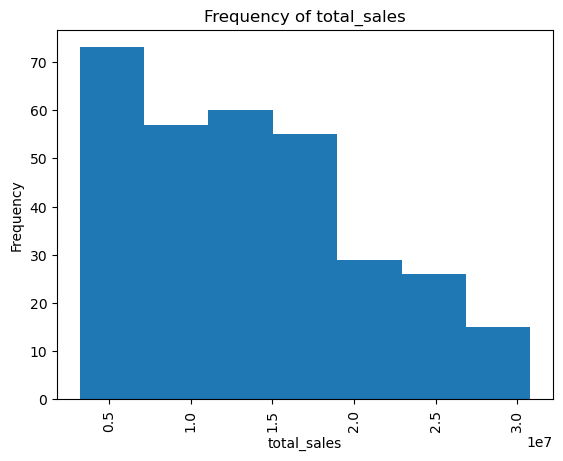

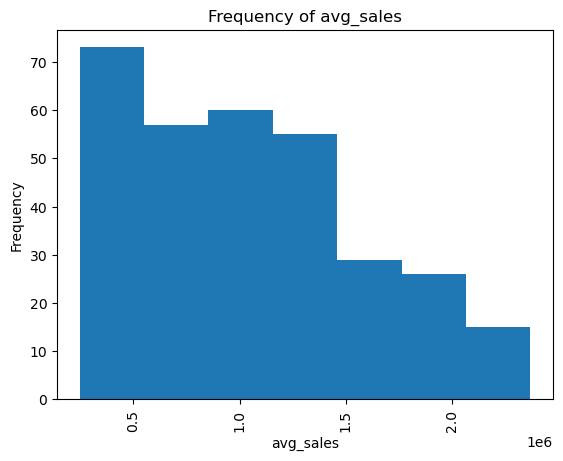

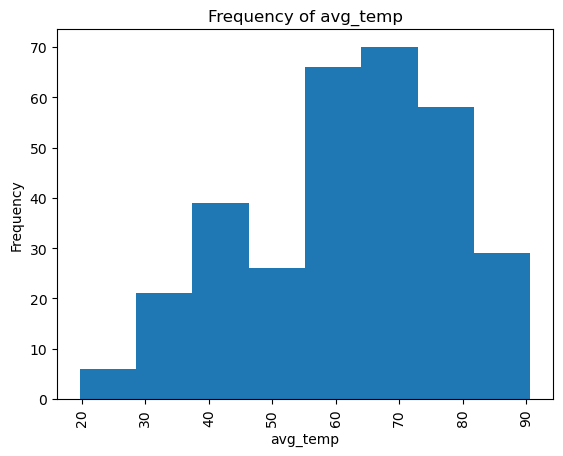

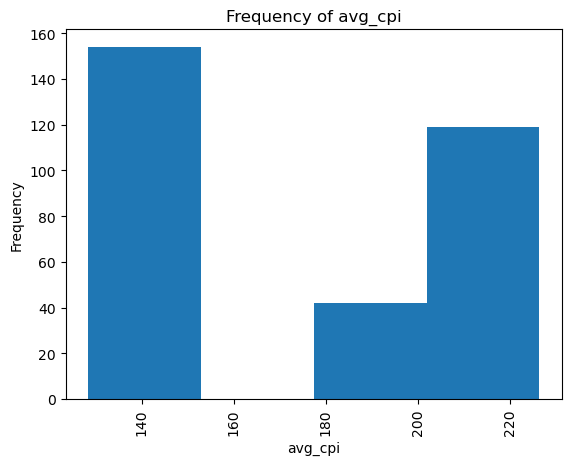

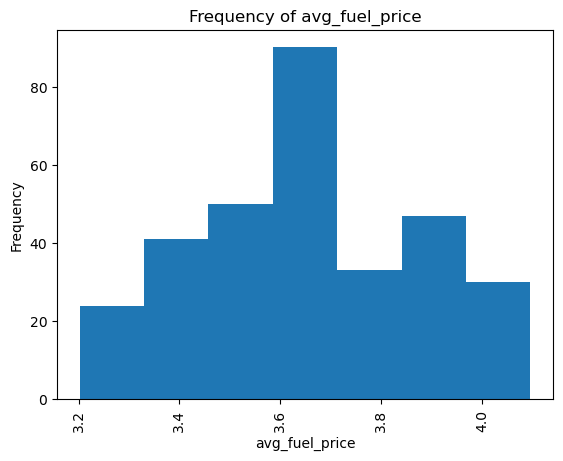

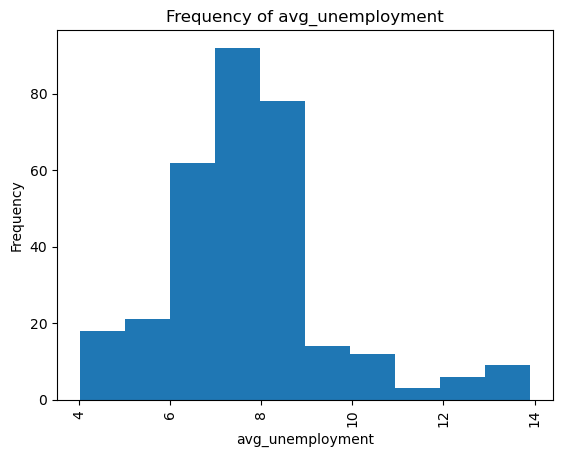

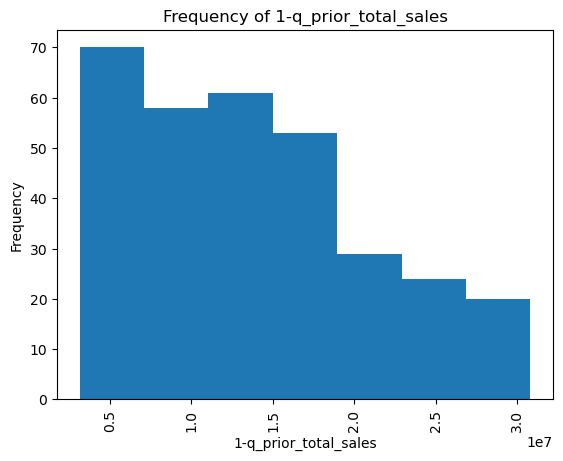

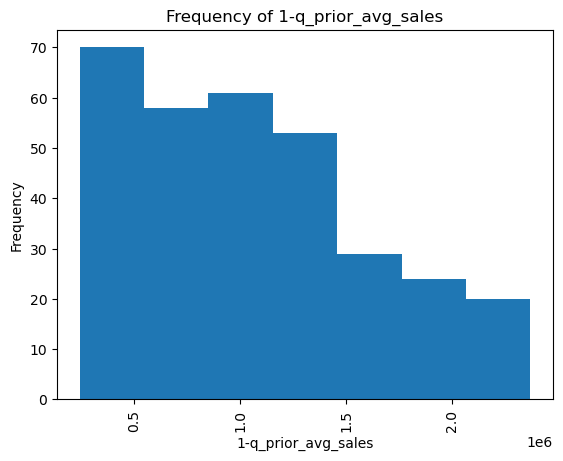

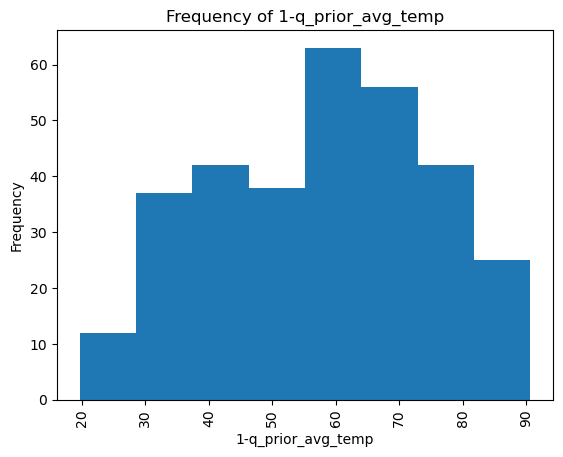

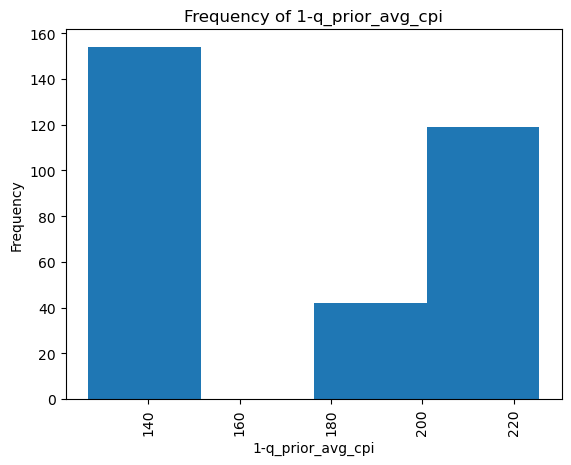

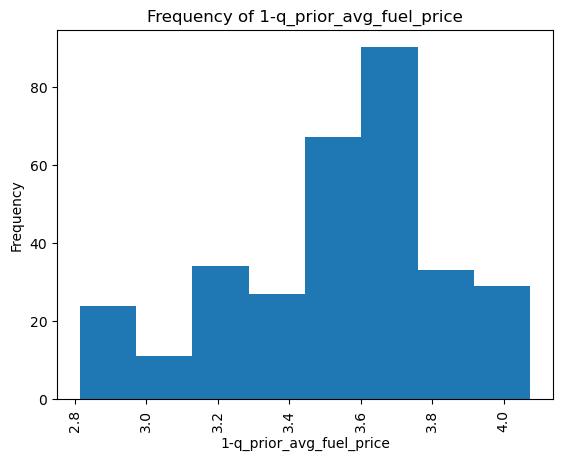

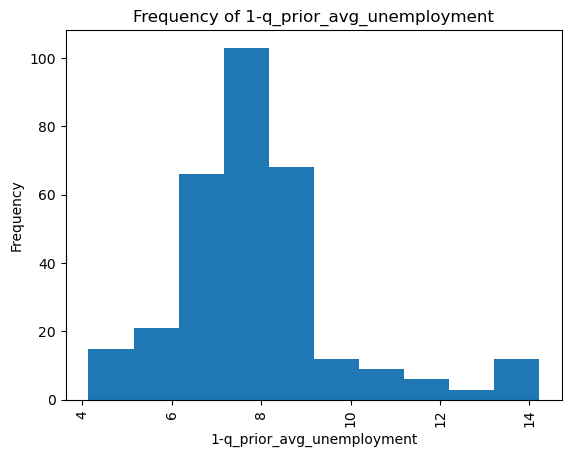

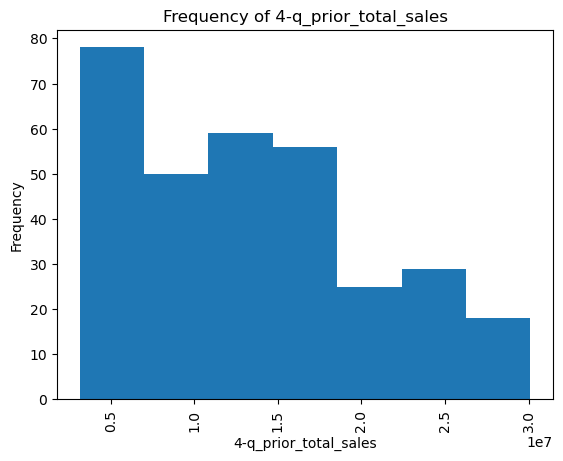

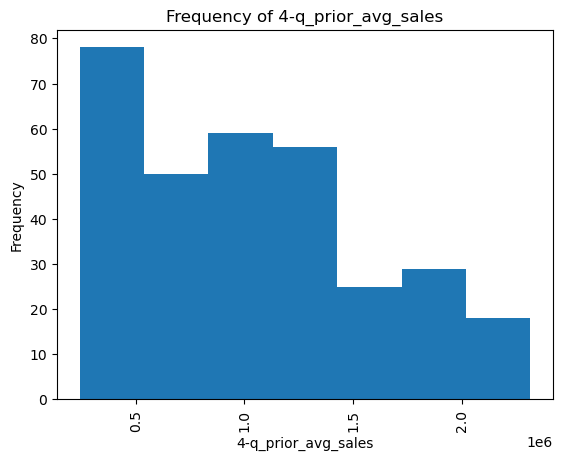

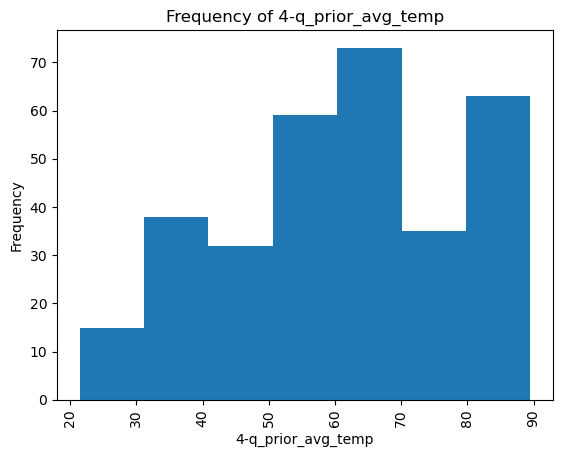

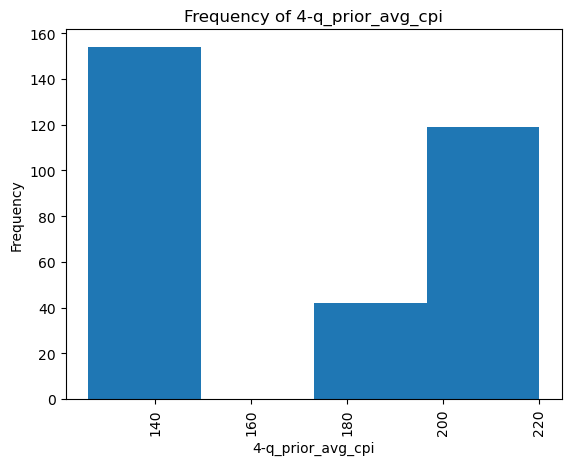

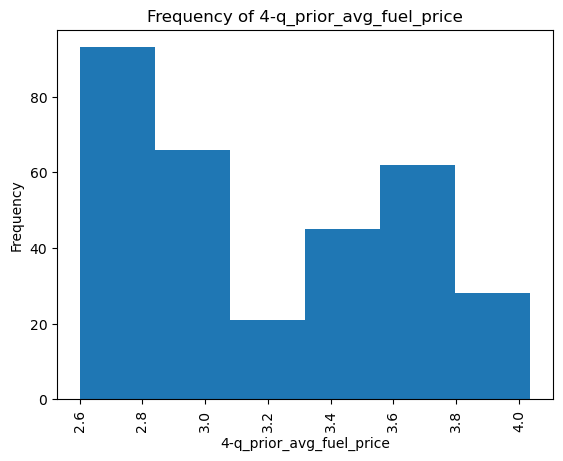

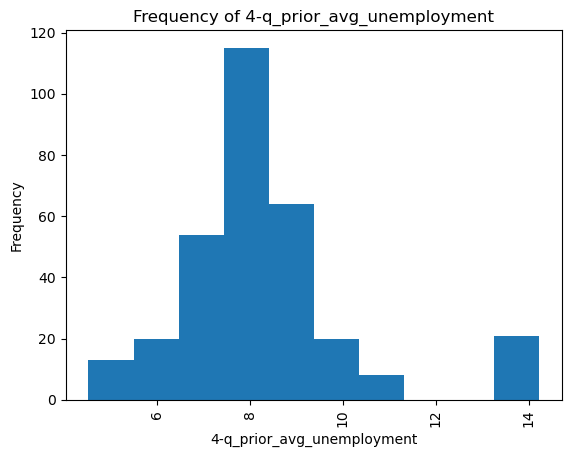

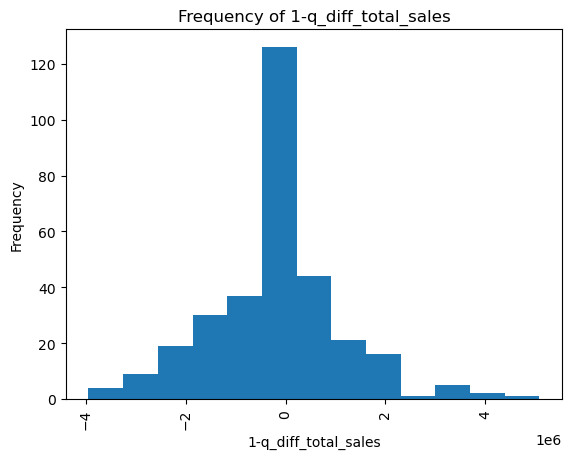

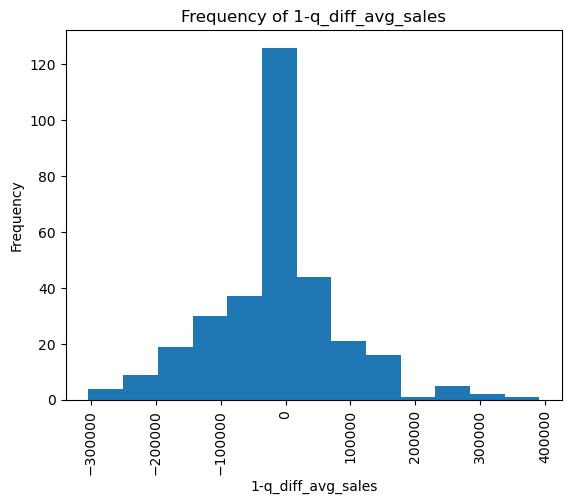

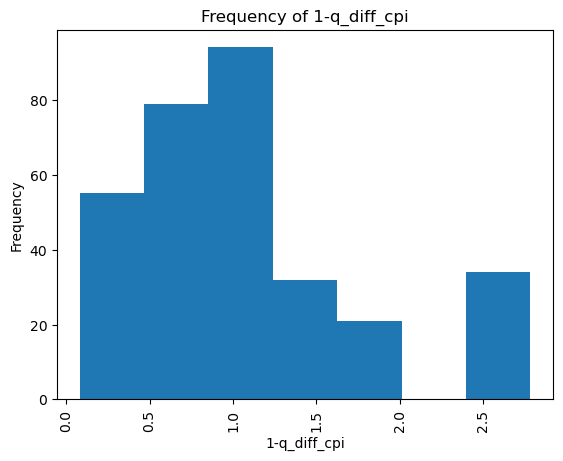

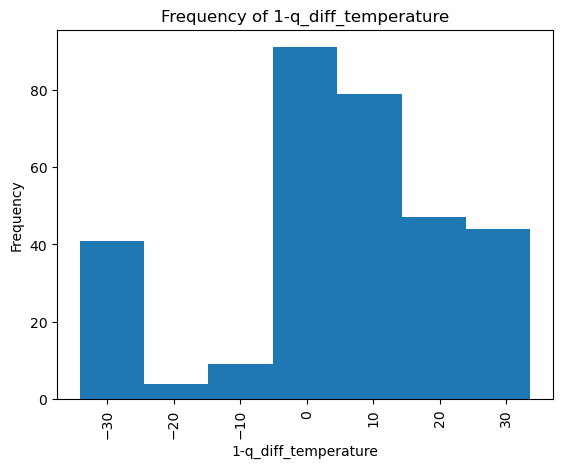

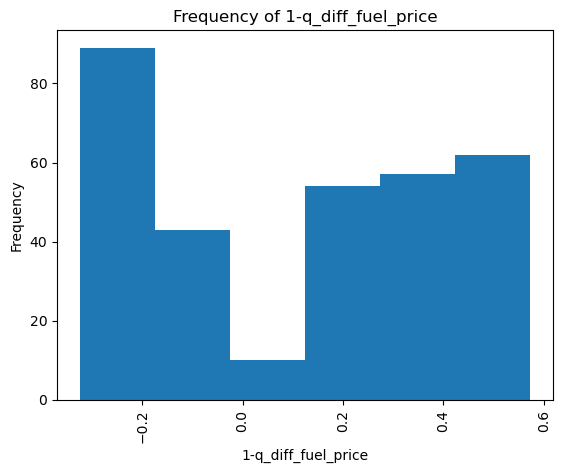

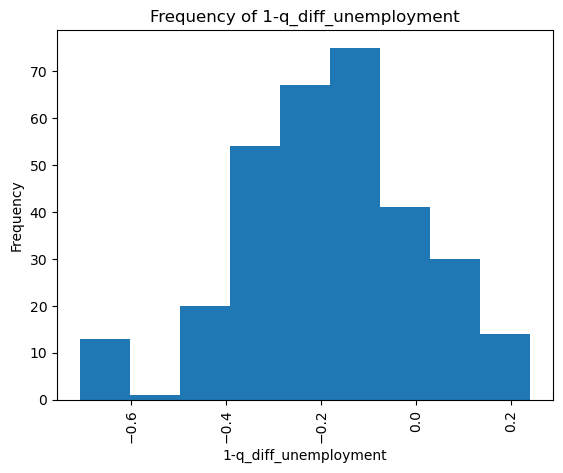

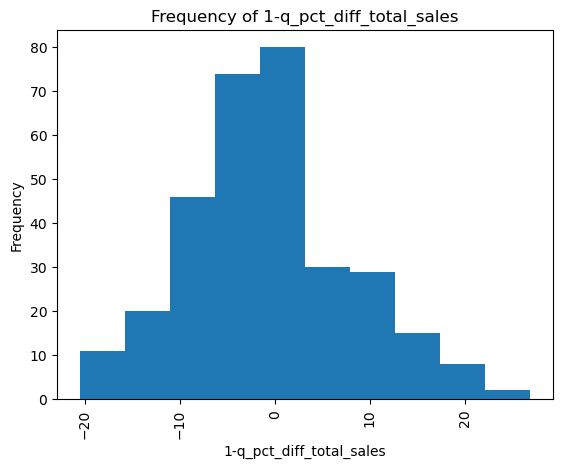

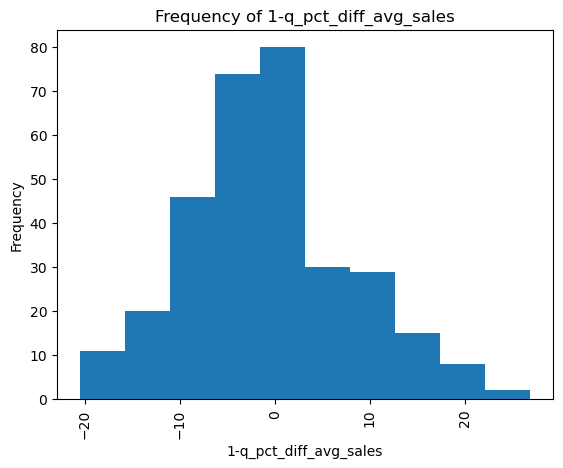

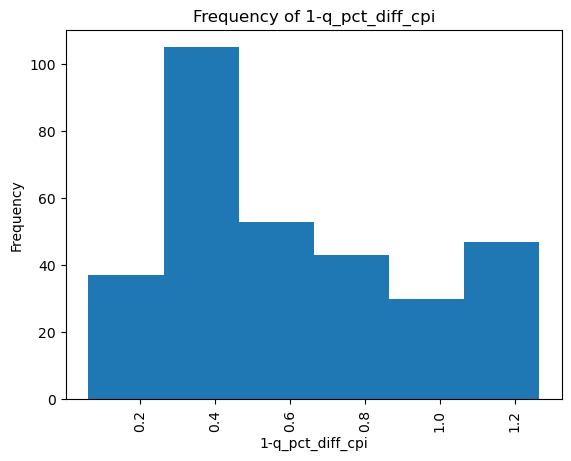

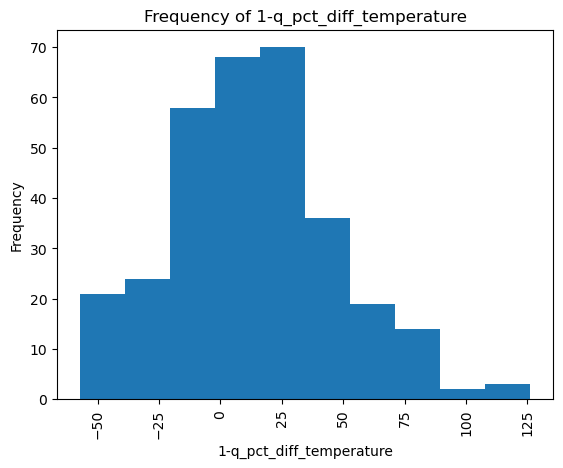

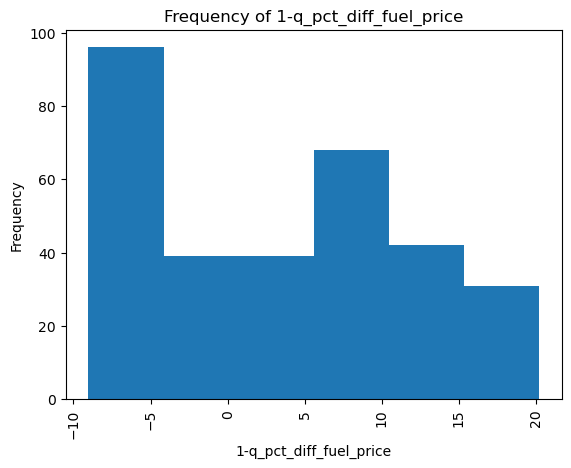

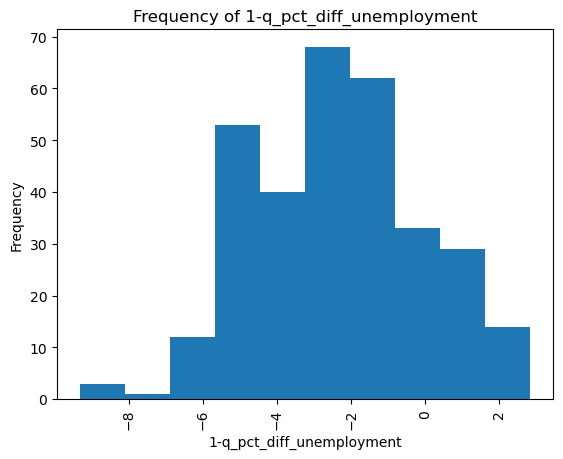

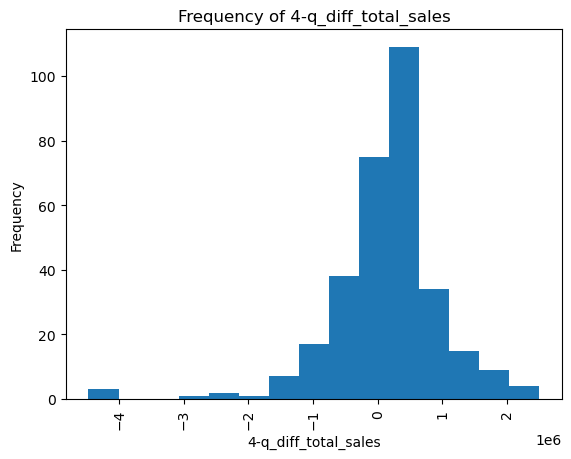

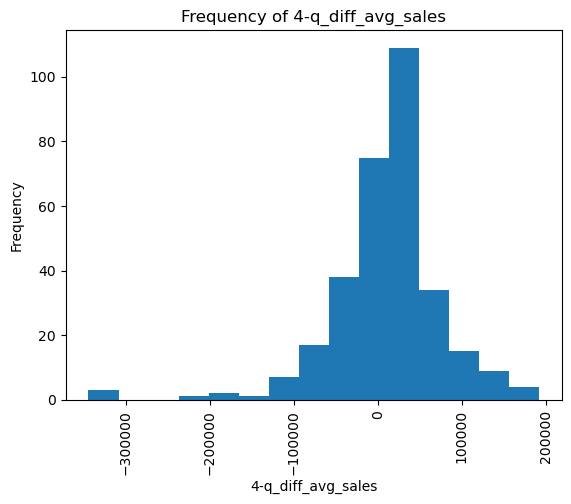

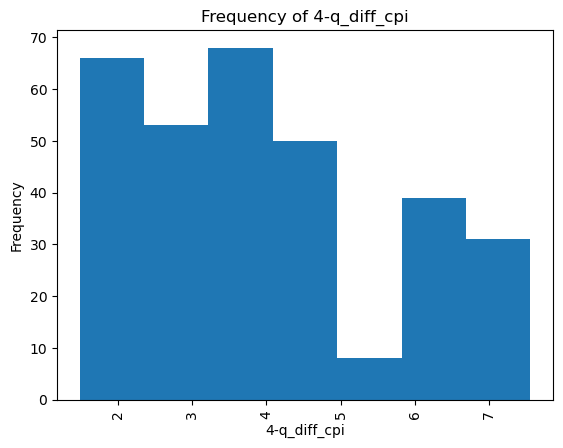

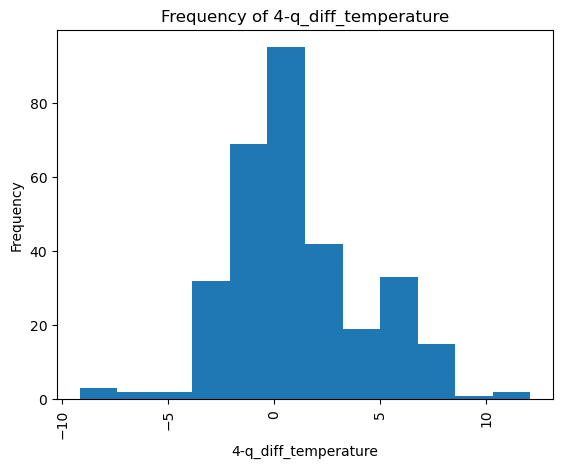

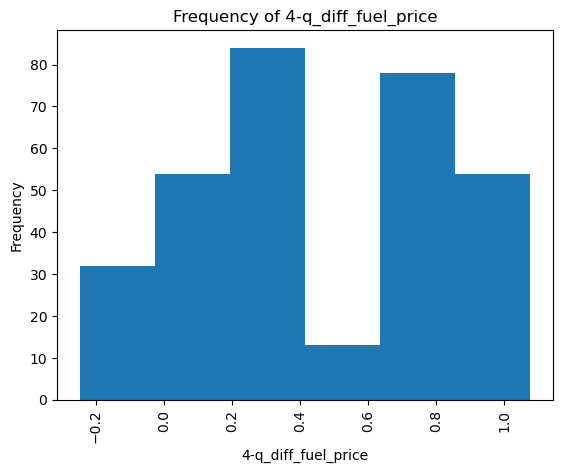

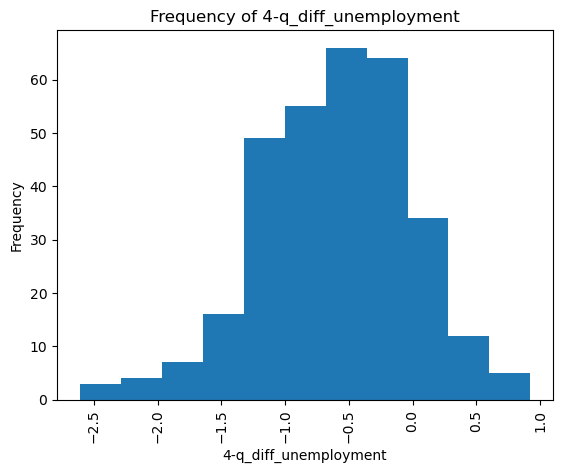

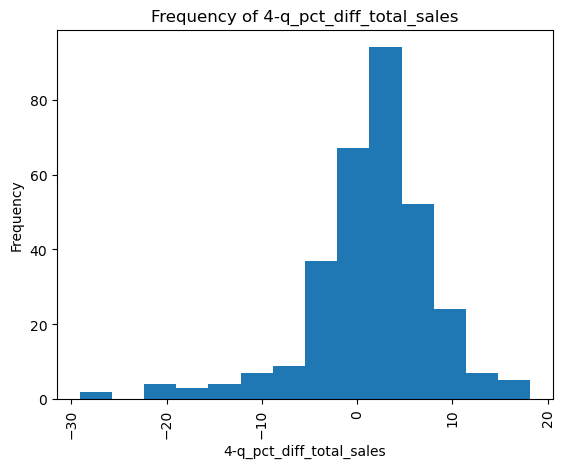

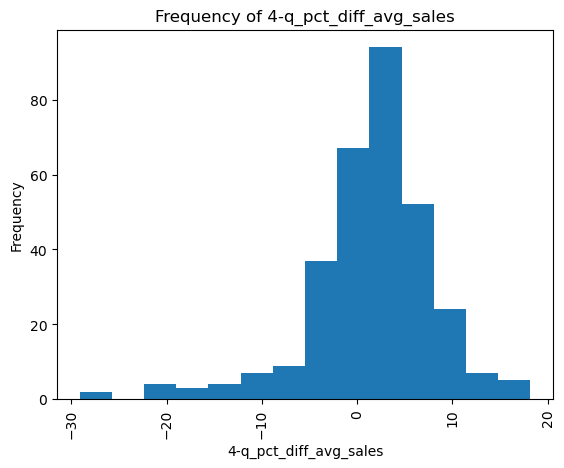

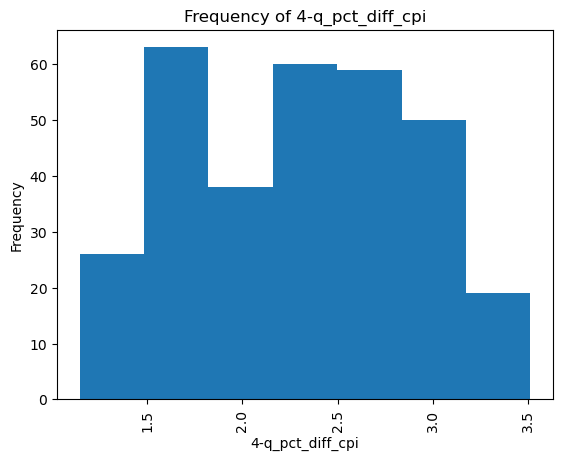

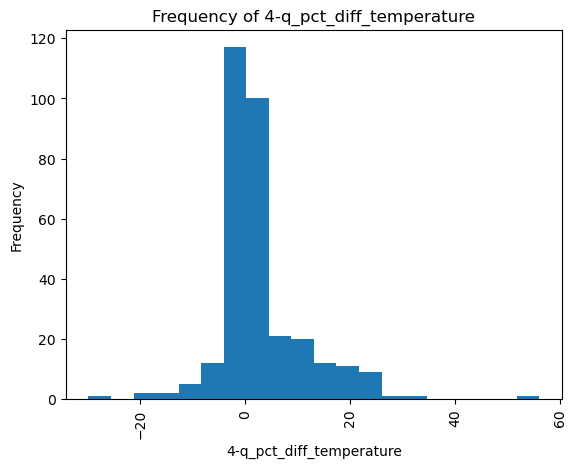

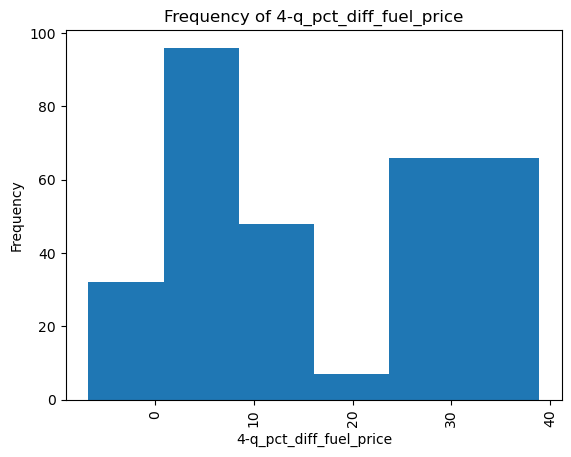

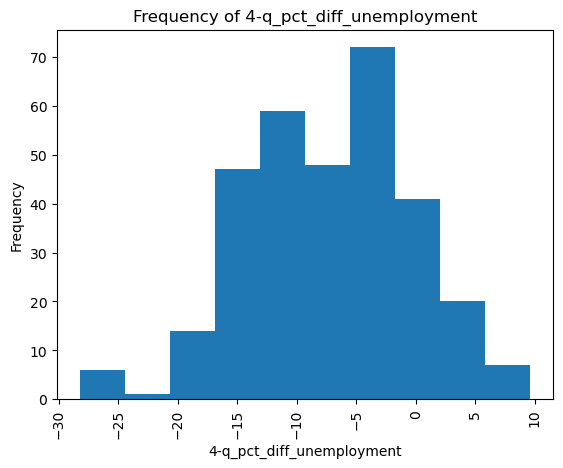

None

In [46]:
display(float_hists(ws_quarterly_full.dropna().copy().reset_index(drop=True)))

#### Frequency of Discrete Variables

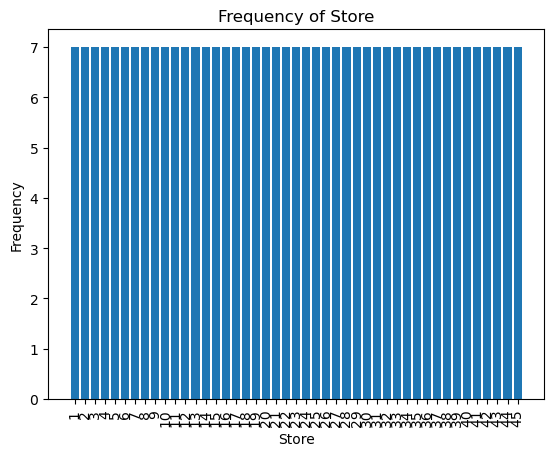

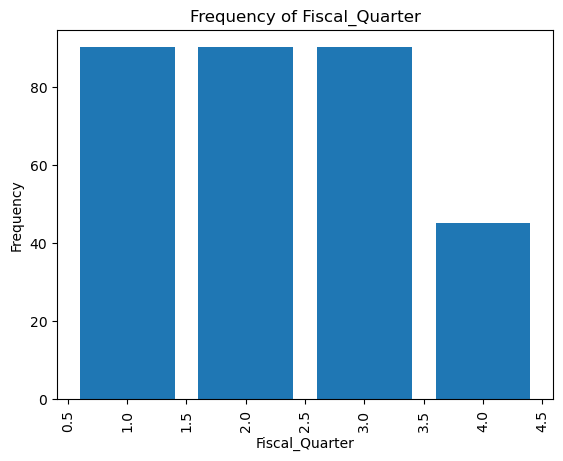

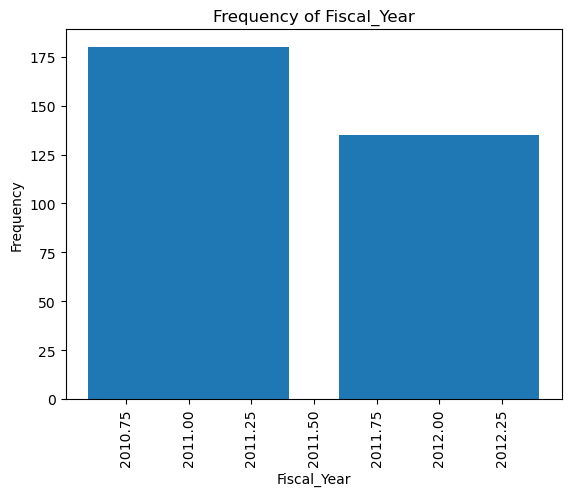

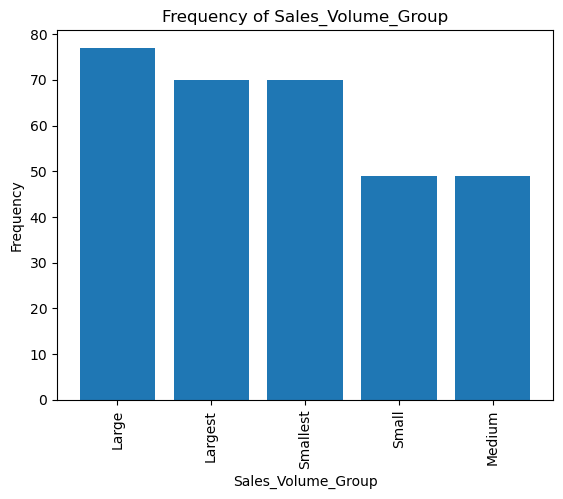

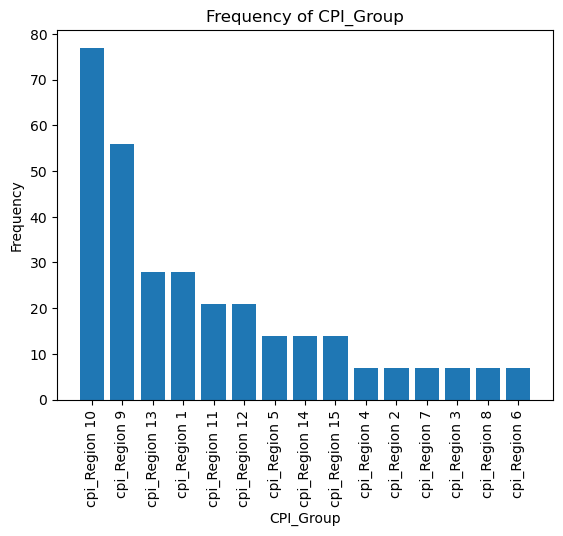

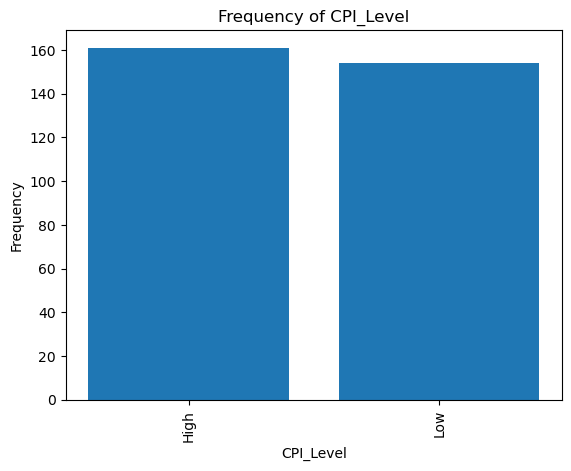

total_sales is float
avg_sales is float
avg_temp is float
avg_cpi is float
avg_fuel_price is float
avg_unemployment is float
1-q_prior_total_sales is float
1-q_prior_avg_sales is float
1-q_prior_avg_temp is float
1-q_prior_avg_cpi is float
1-q_prior_avg_fuel_price is float
1-q_prior_avg_unemployment is float
4-q_prior_total_sales is float
4-q_prior_avg_sales is float
4-q_prior_avg_temp is float
4-q_prior_avg_cpi is float
4-q_prior_avg_fuel_price is float
4-q_prior_avg_unemployment is float
1-q_diff_total_sales is float
1-q_diff_avg_sales is float
1-q_diff_cpi is float
1-q_diff_temperature is float
1-q_diff_fuel_price is float
1-q_diff_unemployment is float
1-q_pct_diff_total_sales is float
1-q_pct_diff_avg_sales is float
1-q_pct_diff_cpi is float
1-q_pct_diff_temperature is float
1-q_pct_diff_fuel_price is float
1-q_pct_diff_unemployment is float
4-q_diff_total_sales is float
4-q_diff_avg_sales is float
4-q_diff_cpi is float
4-q_diff_temperature is float
4-q_diff_fuel_price is float
4-

None

In [47]:
display(nonfloat_freq(ws_quarterly_full.dropna().copy().reset_index(drop=True)))

### Section VII: Driver Analysis

#### Quarterly Driver Analysis - Continuous, Unsegmented

In [48]:
ws_quarterly_continuous = ws_quarterly_full.copy()
display(ws_quarterly_continuous)
display(list(ws_quarterly_continuous.columns))

,Store,Fiscal_Quarter,Fiscal_Year,Sales_Volume_Group,CPI_Group,CPI_Level,total_sales,avg_sales,avg_temp,avg_cpi,...,4-q_diff_cpi,4-q_diff_temperature,4-q_diff_fuel_price,4-q_diff_unemployment,4-q_pct_diff_total_sales,4-q_pct_diff_avg_sales,4-q_pct_diff_cpi,4-q_pct_diff_temperature,4-q_pct_diff_fuel_price,4-q_pct_diff_unemployment
0,1,1,2010,Large,cpi_Region 10,High,19601440.00,1.507803e+06,54.184615,210.974804,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,2010,Large,cpi_Region 10,High,19258503.14,1.481423e+06,80.270769,211.050275,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,2010,Large,cpi_Region 10,High,19056388.62,1.465876e+06,77.806154,211.651038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,2010,Large,cpi_Region 10,High,20842551.21,1.603273e+06,50.155385,211.674877,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,2011,Large,cpi_Region 10,High,20396386.65,1.568953e+06,60.622308,214.267338,...,3.292534,6.437692,0.732615,-0.272462,4.055552,4.055552,1.560629,11.881034,27.359168,-3.409441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,45,3,2011,Small,cpi_Region 4,High,9661366.82,7.431821e+05,67.496923,187.008997,...,4.322478,-0.771538,0.905692,-0.142077,2.554382,2.554382,2.366063,-1.130154,32.585171,-1.626396
491,45,4,2011,Small,cpi_Region 4,High,11604623.60,8.926634e+05,42.708462,188.768282,...,6.012140,7.023846,0.371538,-0.177615,1.805414,1.805414,3.289706,19.683121,11.965516,-2.048584
492,45,1,2012,Small,cpi_Region 4,High,10259780.79,7.892139e+05,48.052308,190.339410,...,5.601276,4.476923,0.296000,-0.070231,4.487611,4.487611,3.032008,10.273973,8.312272,-0.822545
493,45,2,2012,Small,cpi_Region 4,High,10263547.59,7.895037e+05,71.473846,191.057802,...,5.111630,-0.729231,-0.203692,0.042000,0.923356,0.923356,2.748984,-1.009972,-5.246993,0.490597


['Store',
 'Fiscal_Quarter',
 'Fiscal_Year',
 'Sales_Volume_Group',
 'CPI_Group',
 'CPI_Level',
 'total_sales',
 'avg_sales',
 'avg_temp',
 'avg_cpi',
 'avg_fuel_price',
 'avg_unemployment',
 '1-q_prior_total_sales',
 '1-q_prior_avg_sales',
 '1-q_prior_avg_temp',
 '1-q_prior_avg_cpi',
 '1-q_prior_avg_fuel_price',
 '1-q_prior_avg_unemployment',
 '4-q_prior_total_sales',
 '4-q_prior_avg_sales',
 '4-q_prior_avg_temp',
 '4-q_prior_avg_cpi',
 '4-q_prior_avg_fuel_price',
 '4-q_prior_avg_unemployment',
 '1-q_diff_total_sales',
 '1-q_diff_avg_sales',
 '1-q_diff_cpi',
 '1-q_diff_temperature',
 '1-q_diff_fuel_price',
 '1-q_diff_unemployment',
 '1-q_pct_diff_total_sales',
 '1-q_pct_diff_avg_sales',
 '1-q_pct_diff_cpi',
 '1-q_pct_diff_temperature',
 '1-q_pct_diff_fuel_price',
 '1-q_pct_diff_unemployment',
 '4-q_diff_total_sales',
 '4-q_diff_avg_sales',
 '4-q_diff_cpi',
 '4-q_diff_temperature',
 '4-q_diff_fuel_price',
 '4-q_diff_unemployment',
 '4-q_pct_diff_total_sales',
 '4-q_pct_diff_avg_sales',

In [49]:
qr_base = ws_quarterly_continuous[['4-q_pct_diff_total_sales','1-q_diff_cpi','avg_fuel_price','1-q_diff_unemployment','4-q_diff_temperature']].dropna().copy().reset_index(drop=True)

qr_i_vars = qr_base.drop(labels=['4-q_pct_diff_total_sales'],axis=1)
qr_d_vars = qr_base['4-q_pct_diff_total_sales']
qr_i_vars = sm.add_constant(qr_i_vars)
qr_r_model = sm.OLS(qr_d_vars,qr_i_vars).fit()
print(qr_r_model.summary())

                               OLS Regression Results                               
Dep. Variable:     4-q_pct_diff_total_sales   R-squared:                       0.089
Model:                                  OLS   Adj. R-squared:                  0.077
Method:                       Least Squares   F-statistic:                     7.580
Date:                      Mon, 01 Jan 2024   Prob (F-statistic):           7.74e-06
Time:                              12:29:26   Log-Likelihood:                -1021.4
No. Observations:                       315   AIC:                             2053.
Df Residuals:                           310   BIC:                             2072.
Df Model:                                 4                                         
Covariance Type:                  nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

'avg_cpi' showed no significant effects, however, change in cpi from previous quarter, '1-q_diff_cpi' was found to be significant (delayed effect on sales) <br>
'avg_fuel_price' was found to be significant (immediate effect seen on sales) <br>
'1-q_diff_unemployment' found to follow similar trend to cpi (delayed effect on sales) <br>
'avg_temp' and '1-q_diff_temperature' found to be insignificant, '4-q_diff_temperature' found to be significant (if hotter than this time previous year, ever so slight increase in sales)

In [50]:
qr_r_model_df = qr_r_model.summary2().tables[1]
display(qr_r_model_df)
#qr_r_model_df.to_csv('walmart_sales_quarter_driver_coeffs.csv')

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,15.853965,6.985483,2.269559,0.023921,2.109007,29.598922
1-q_diff_cpi,-1.894094,0.569083,-3.328327,0.000979,-3.013847,-0.774340
avg_fuel_price,-3.828851,1.809311,-2.116193,0.035125,-7.388934,-0.268767
1-q_diff_unemployment,-7.274185,1.917814,-3.792957,0.000179,-11.047764,-3.500606
4-q_diff_temperature,0.259849,0.112271,2.314476,0.021295,0.038939,0.480759
